**1. Setup and Data Preparation:**
- Import necessary libraries: pandas, matplotlib, scikit-learn.
- Load the dataset for logistic regression modeling.
- Preprocess the data, handle missing values, and encode categorical variables.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

# Load the dataset (replace 'car.csv' with your actual dataset path)
df = pd.read_csv('car.csv')

df.head()

,Buying_Price,Maintenance_Price,No_of_Doors,Person_Capacity,Size_of_Luggage,Safety,Car_Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [12]:
df.isnull().any().sum()

np.int64(0)

In [13]:
df.duplicated().sum()

np.int64(0)

In [3]:

# Split features and target variable
X = df.drop('Car_Acceptability', axis=1)  # Features
y = df['Car_Acceptability']  # Target variable

# Preprocessing for numeric columns (handle missing and scale)
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Standardize features
])

# Preprocessing for categorical columns (handle missing and encode them)
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for categorical variables
])

# Combine transformations into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

**2. Logistic Regression Parameters:**
- Choose appropriate hyperparameters such as regularization strength and solver based on
data exploration.


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Logistic Regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(max_iter=1000))])

# Define the hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],  # Solvers to try
    'classifier__penalty': ['l1', 'l2'],  # Penalties to try
}

***3. Building the Logistic Regression Model:***
- Initialize the Logistic Regression model with selected parameters.
- Train the Logistic Regression model on the prepared training data.

***4. Model Evaluation:***
- Evaluate the trained model using appropriate metrics such as accuracy, precision, recall,
F1-score, and ROC-AUC.
- Visualize the logistic regression model to interpret the learned coefficients and feature
importance.


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Train the model
model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)  # Probability estimates for ROC-AUC

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average = 'weighted')
recall = recall_score(y_test, y_pred,average = 'weighted')
f1 = f1_score(y_test, y_pred,average = 'weighted')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='weighted')


# Print evaluation metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-Score: {f1 * 100:.2f}%')
print(f'ROC-AUC: {roc_auc:.2f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

Accuracy: 91.52%
Precision: 91.32%
Recall: 91.52%
F1-Score: 91.36%
ROC-AUC: 0.99
Confusion Matrix:
[[102   6  10   0]
 [  9   7   0   3]
 [ 12   1 345   0]
 [  3   0   0  21]]


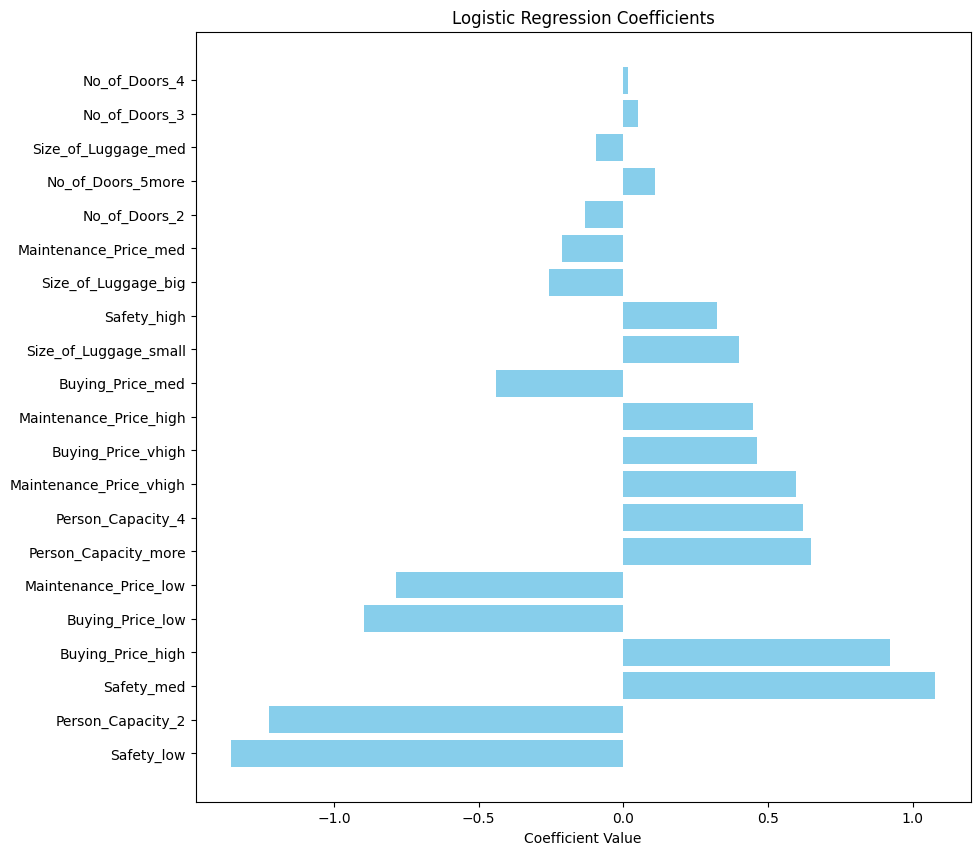

In [10]:

# Access the Logistic Regression model from the pipeline
classifier = model.named_steps['classifier']

# Access the preprocessor (ColumnTransformer) from the pipeline
preprocessor = model.named_steps['preprocessor']

# Access the OneHotEncoder inside the preprocessor
one_hot_encoder = preprocessor.transformers_[1][1].named_steps['onehot']

# Get the feature names after one-hot encoding (important for categorical features)
one_hot_features = one_hot_encoder.get_feature_names_out(categorical_features)

# Combine numeric features with the one-hot encoded categorical features
all_feature_names = list(numeric_features) + list(one_hot_features)

# Get the coefficients from the trained Logistic Regression model
coefficients = classifier.coef_[0]

# Create a DataFrame for easy visualization
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients (to highlight important features)
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Visualize the coefficients
plt.figure(figsize=(10, 10))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()


**5. Hyperparameter Tuning and Optimization:**
- Perform hyperparameter tuning using techniques like grid search or random search to
optimize model performance.
- Validate the optimized model using cross-validation techniques.

In [11]:

# Perform GridSearchCV for hyperparameter tuning
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)  # 5-fold cross-validation
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best parameters and score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_ * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'classifier__solver': 'newton-cg', 'classifier__penalty': 'l2', 'classifier__C': 100}
Best Cross-validation Accuracy: 93.55%


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

In [14]:
# Best model from grid search
best_model = grid_search.best_estimator_

# Evaluate the optimized model with cross-validation (on the entire dataset)
cross_val_score_result = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-Validation Accuracy: {cross_val_score_result.mean() * 100:.2f}%")


Cross-Validation Accuracy: 77.66%


In [15]:
# Test accuracy using the best model
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 93.83%
